In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

# Imports Libraries 

In [6]:
import os  
import numpy as np
import pandas as pd
import random  
from PIL import Image, ImageEnhance  
from tensorflow.keras.preprocessing.image import load_img  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense 
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.applications import VGG16  
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr 
wr.filterwarnings("ignore")


# Load Datasets

In [7]:
def load_data_to_df(data_dir):
    paths = []
    labels = []
    
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                paths.append(os.path.join(label_path, image))
                labels.append(label)
    
    df = pd.DataFrame({'image_path': paths, 'label': labels})
    df = shuffle(df).reset_index(drop=True)
    return df


train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

train_df = load_data_to_df(train_dir)
test_df = load_data_to_df(test_dir)

print(train_df.head())
print(test_df.head())


                                          image_path       label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma
1  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma
2  /kaggle/input/brain-tumor-mri-dataset/Training...     notumor
3  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
4  /kaggle/input/brain-tumor-mri-dataset/Training...   pituitary
                                          image_path       label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...   pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor


# Data Visualization

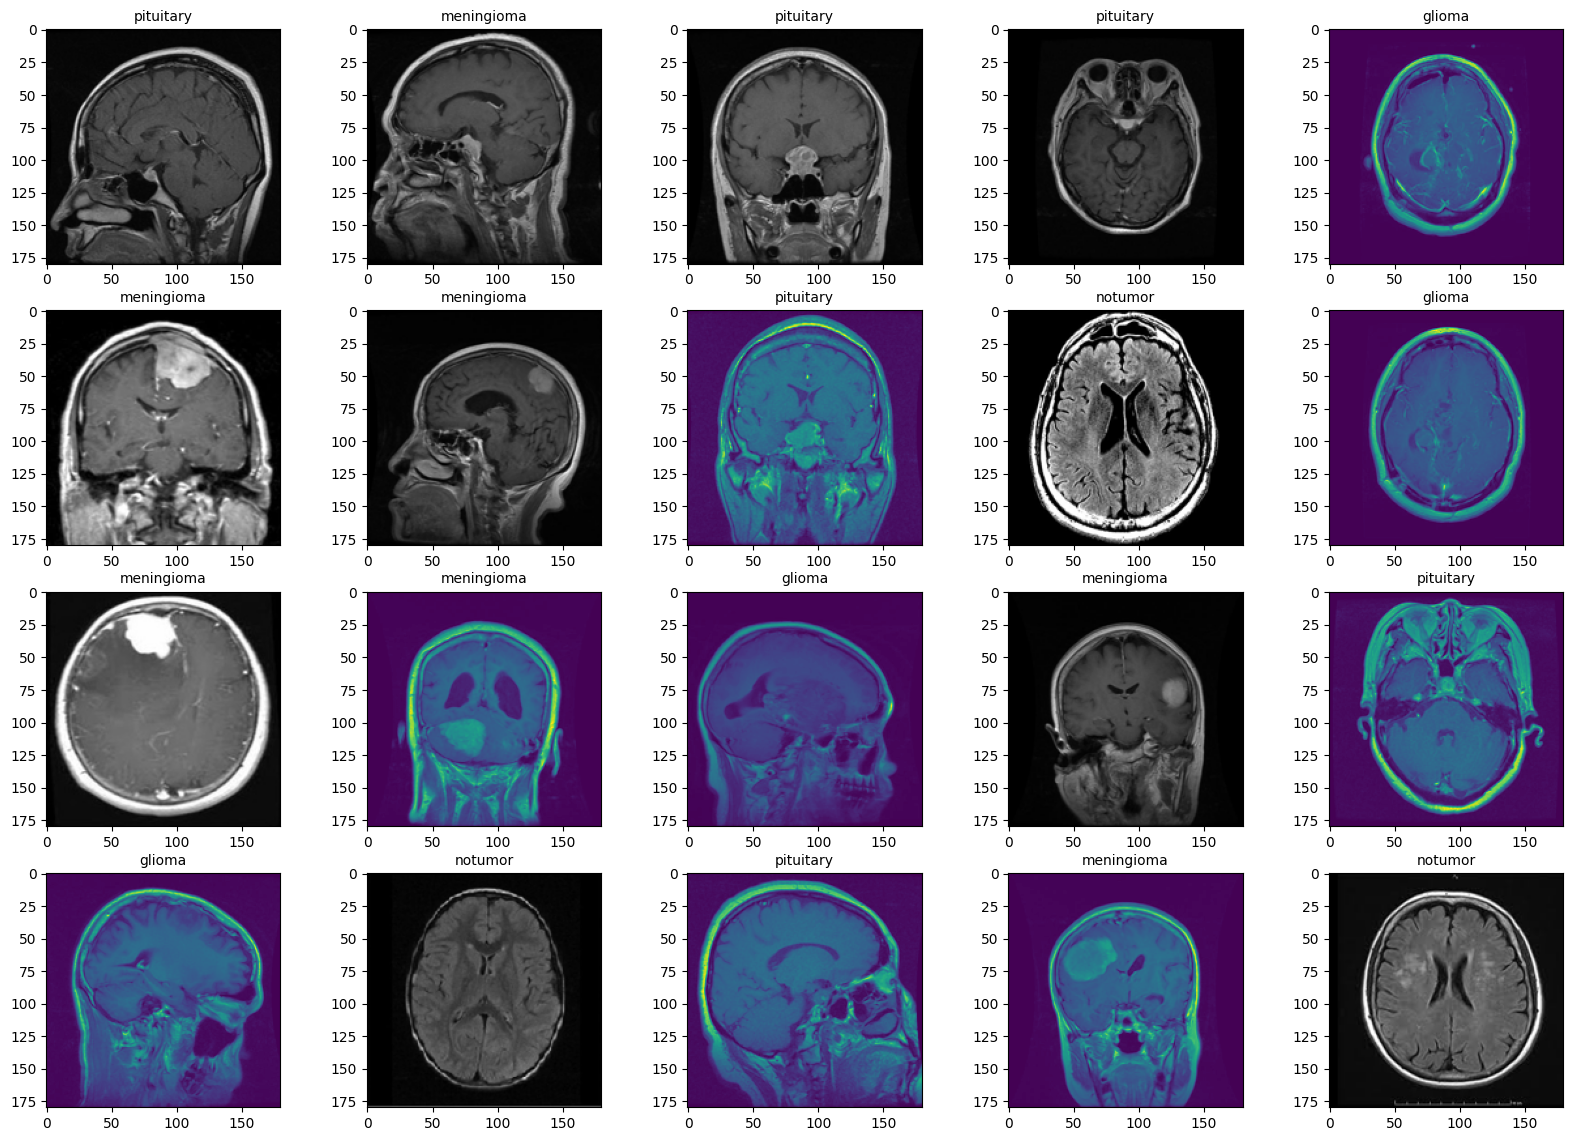

In [8]:
indices = random.sample(range(len(train_df)), 20)

plt.figure(figsize=(20, 14))

for i, idx in enumerate(indices):
    img = Image.open(train_df.loc[idx, 'image_path']).resize((180, 180))
    plt.subplot(4, 5, i+1)
    plt.imshow(img)

    plt.title(train_df.loc[idx, 'label'], fontsize=10)  
plt.show()

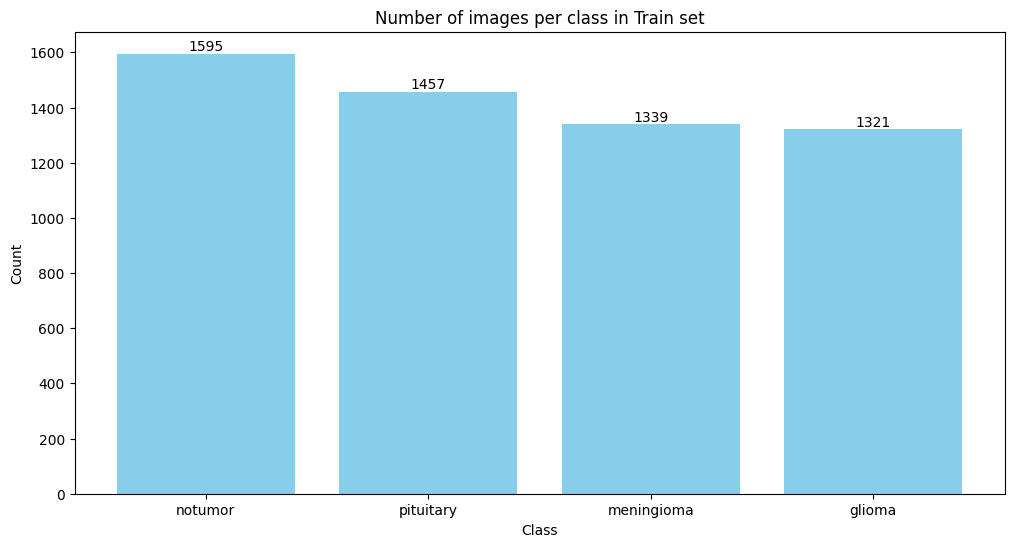

In [9]:

train_counts = train_df['label'].value_counts()
plt.figure(figsize=(12, 6))
bars = plt.bar(train_counts.index, train_counts.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=10)

plt.title("Number of images per class in Train set")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

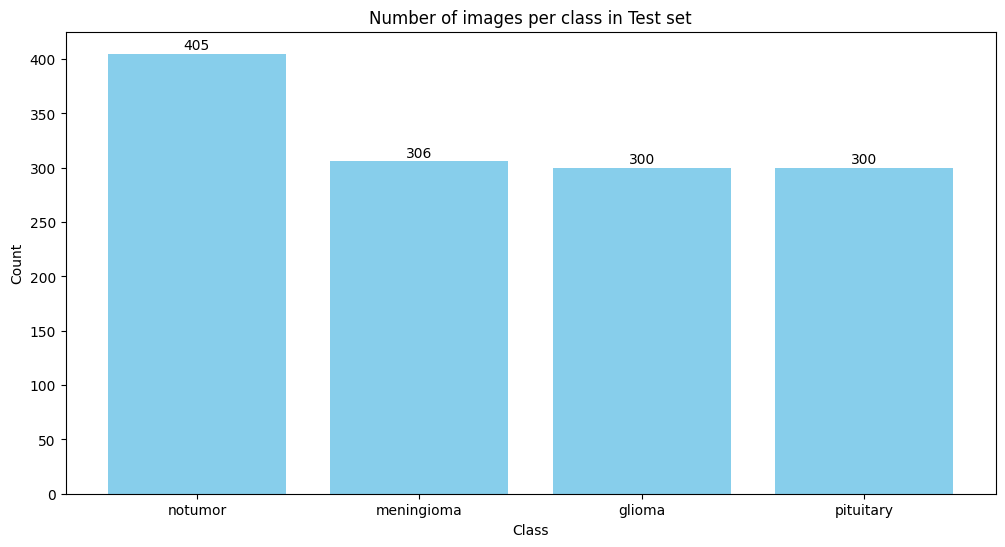

In [10]:

test_counts = test_df['label'].value_counts()

plt.figure(figsize=(12, 6))
bars = plt.bar(test_counts.index, test_counts.values, color='skyblue')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=10)

plt.title("Number of images per class in Test set")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

# Image Preprocessing (Helper Functions)

In [11]:
# Image augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2)) 
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))    
    image = np.array(image) / 255.0  
    return image

# Load images and apply augmentation
def open_images(paths, image_size):
    images = []
    for path in paths:
        image = load_img(path, target_size=(image_size, image_size))
        image = np.array(image)
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encode labels using unique labels from DataFrame
def encode_label(labels, unique_labels):
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    encoded = [label_to_index[label] for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(train_df, batch_size=12, epochs=1, image_size=128):
    unique_labels = train_df['label'].unique().tolist()  
    
    paths = train_df['image_path'].tolist()
    labels = train_df['label'].tolist()
    
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            batch_images = open_images(batch_paths, image_size)
            batch_labels = encode_label(batch_labels, unique_labels)

            yield batch_images, batch_labels


# MODEL Usind VGG16

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

In [12]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  
model.add(Flatten())  
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])



# Parameters
batch_size = 20
steps = int(len(train_df) / batch_size)  
epochs = 5

model.summary()


I0000 00:00:1757717648.044599      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757717648.045303      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [13]:

batch_size = 20
steps = int(len(train_df) / batch_size)  
epochs = 5

history = model.fit(
    datagen(
        train_df, 
        batch_size=batch_size, 
        epochs=epochs, 
        image_size=IMAGE_SIZE
    ),
    epochs=epochs,
    steps_per_epoch=steps
)



Epoch 1/5


I0000 00:00:1757717653.235016     105 service.cc:148] XLA service 0x798c980115c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757717653.236171     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757717653.236192     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757717653.683848     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/285 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - loss: 1.8690 - sparse_categorical_accuracy: 0.2000 

I0000 00:00:1757717659.780970     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


285/285 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - loss: 0.6823 - sparse_categorical_accuracy: 0.7216
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - loss: 0.2448 - sparse_categorical_accuracy: 0.9075
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - loss: 0.1775 - sparse_categorical_accuracy: 0.9314
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.9556
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 0.1124 - sparse_categorical_accuracy: 0.9572


# Train and Val Plots

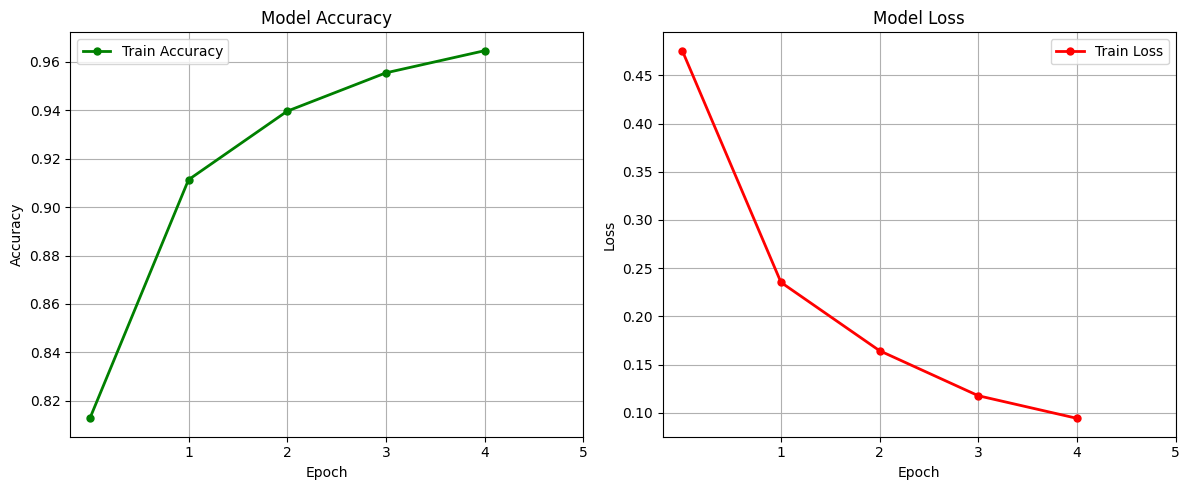

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax1.plot(history.history['sparse_categorical_accuracy'], 'o-', color='green', linewidth=2, markersize=5, label='Train Accuracy')
if 'val_accuracy' in history.history:
    ax1.plot(history.history['val_accuracy'], 's-', color='blue', linewidth=2, markersize=5, label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.set_xticks(range(1, epochs + 1))
ax1.legend()

# Plot Loss
ax2.plot(history.history['loss'], 'o-', color='red', linewidth=2, markersize=5, label='Train Loss')
if 'val_loss' in history.history:
    ax2.plot(history.history['val_loss'], 's-', color='orange', linewidth=2, markersize=5, label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.set_xticks(range(1, epochs + 1))
ax2.legend()

plt.tight_layout()
plt.show()


# Model Classification Report

In [15]:

test_images = open_images(test_df['image_path'].tolist(), IMAGE_SIZE)

unique_labels = train_df['label'].unique()  
test_labels_encoded = encode_label(test_df['label'].tolist(), unique_labels)

test_predictions = model.predict(test_images)


print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1), target_names=unique_labels))



41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 258ms/step
Classification Report:
              precision    recall  f1-score   support

  meningioma       0.89      0.94      0.92       306
     notumor       0.98      1.00      0.99       405
      glioma       0.96      0.89      0.92       300
   pituitary       0.99      0.98      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



# Model Confusion Plot

Confusion Matrix:
[[288   6  10   2]
 [  0 404   1   0]
 [ 32   1 267   0]
 [  3   1   1 295]]


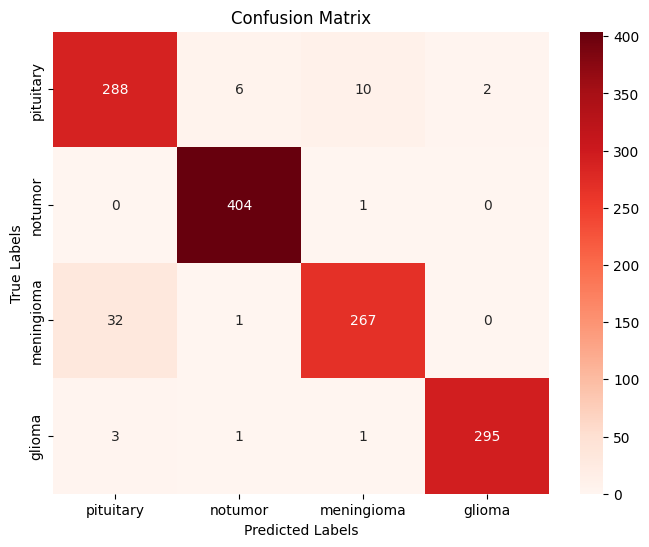

In [16]:

conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Save & Load Model

In [17]:

model.save('BRAIN_TUMOR_last_ver.h5')

In [18]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/BRAIN_TUMOR_last_ver.h5')

# MRI Tumor Detection System

In [19]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

  
    img = Image.open(img_path).convert("RGB")
    resized_img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = np.asarray(resized_img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

  
    predictions = model.predict(img_array)
    probs = predictions[0]
    labels = list(unique_labels)

  
    top_idx = np.argmax(probs)
    top_label = labels[top_idx]
    top_conf = probs[top_idx] * 100

  
    plt.imshow(resized_img)
    plt.axis("off")
    plt.title(f"Prediction: {top_label} ({top_conf:.2f}%)", fontsize=14)
    plt.show()


# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


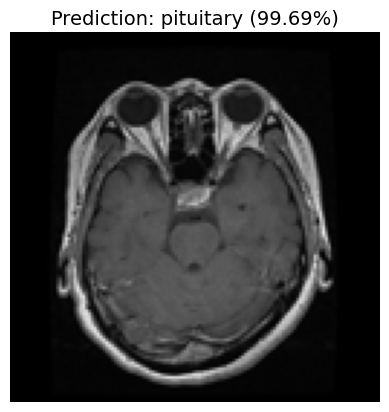

In [21]:

predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0134.jpg') 
